# Script para el oscilador armónico

*Laboratorio F1(ByG), Verano 2018*

Lo que se presenta a continuación es un script que nos permite tomar datos que tengamos en un archivo de la computadora (que adquirimos en un bloc de notas, en un Excel, un .csv, un .dat o el formato de datos que tengan. Una vez tomados los datos, los graficamos.

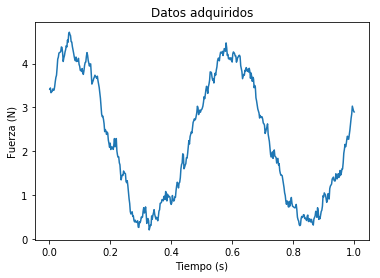

In [3]:
# Primero importamos las bibliotecas que necesitamos

import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import rc


# Definimos una función para leer un archivo de texto y convertirlo a vectores (copian y pegan)

def leermd(filename):
    result = []
    from pandas import read_csv
    import numpy as np
    # Leer el archivo, separado por tabulaciones, salteando 3 lineas de header
    #     y empleando la coma como separador decimal
    df = read_csv(filename, sep='\t', skiprows=4, decimal=',')
    # Convertir el dataframe de pandas a un array de numpy
    nparray = df.as_matrix()
    # Remover los posibles nans del archivo
    nparray = nparray[~np.isnan(nparray).any(axis=1)]
    # Asignar las columnas a variables de salida
    for cols in range(nparray.shape[1]):
        out = nparray[:,cols]
        result.append(out)
        
    return result

# Usamos esa función para leer nuestros datos adquiridos por el DAQ. En este ejemplo:

t,y=leermd("datos_2.csv")


# Seleccionamos algunos puntos en función de nuestro muestreo (opcional)
t = t[0:500]
y = y[0:500]


# Graficamos
plt.plot(t,y)

plt.title('Datos adquiridos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Fuerza (N)')

plt.show()


Hasta acá era lo que sabíamos. También sabíamos hacer un ajuste no lineal con la función *curve_fit* de la biblioteca *scipy.optimize*

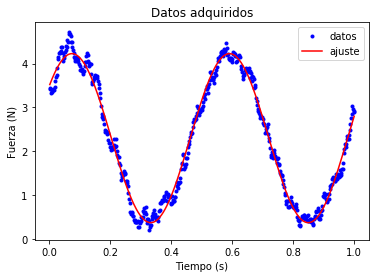

In [7]:
# Importamos la funcion que hace los ajustes

from scipy.optimize import curve_fit


# Definimos una funcion que ajuste
def func(t, a,b,w,d):
    return  a * np.cos(w*t)+b*np.sin(w*t) + d


# Hacemos el ajuste lineal
popt, pcov = curve_fit(func, t, y,p0=[2.5,2.5,12,2.5])

# Graficamos la curva original y la ajustada
plt.plot(t,y,'b.', linewidth = label = 'datos')
plt.plot(t,func(t,popt[0],popt[1],popt[2],popt[3]),'r',label = 'ajuste')

plt.title('Datos adquiridos y su ajuste')
plt.xlabel('Tiempo (s)')
plt.ylabel('Fuerza (N)')
plt.legend(loc = 'best')

plt.show()


#plt.legend(loc='upper left')

In [9]:
print('parametros = ', popt)
print('y la matriz de covarianza es')
print(pcov)

parametros =  [  1.18557776   1.52034268  12.16538821   2.29759648]
y la matriz de covarianza es
[[  4.08350349e-04  -2.35961681e-04  -3.52234056e-04   3.04714102e-05]
 [ -2.35961681e-04   3.20100805e-04   2.96942418e-04  -2.29481608e-05]
 [ -3.52234056e-04   2.96942418e-04   4.46181407e-04  -3.32789288e-05]
 [  3.04714102e-05  -2.29481608e-05  -3.32789288e-05   6.56753401e-05]]


Hasta acá sabíamos, aunque no venía mal un repaso. Lo nuevo viene ahora.

## Oscilador armónico amortiguado: método de detección de picos

Lo que vamos a hacer es, de la señal que tenemos, identificar los máximos puntos, para luego ver si logramos observar la tendencia de caída exponencial. Recordemos que para el amortiguado tenemos que

$$ x(t) = Ae^{-\gamma}cos(\omega t + \phi) $$

Queremos hallar el exponente $\gamma$

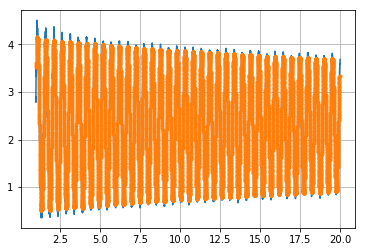

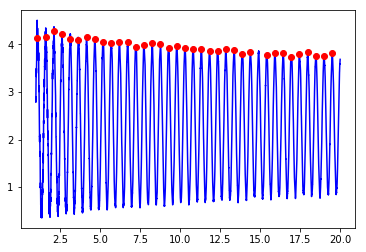

In [17]:
# Definimos estas funciones que se encargarán de hallar los picos

def media_movil(t,y,HW):
    """
    Calculo de la media movil 
    """
    N = np.size(y)
    W = np.round(2*HW).astype(int)
    
    ymm = np.zeros(N-2*HW)
    tmm = np.zeros(N-2*HW)
    
    for i in np.arange(HW,N-HW):
        ymm[i-HW] = np.mean( y[i-HW:i+HW] )
        tmm[i-HW] = t[i]
        
    return tmm, ymm


# Leemos y seleccionamos los datos
t,y=leermd("datos_2.csv")
t = t[500:]
y = y[500:]

tmm, ymm = media_movil(t,y,20)
len(ymm)

plt.figure()
plt.plot(t,y)
plt.plot(tmm,ymm,'.-')
plt.grid('on')

def hallar_picos(to,yo,HW,Npasadas=1):
    
    tS = to
    yS = yo
    
    for i in range(Npasadas):
        tS, yS = media_movil(tS,yS,HW)
    
    tp = np.empty((0, 1))
    yp = np.empty((0, 1))
    
    for i in range(1,len(yS)-1):
        if (yS[i-1] < yS[i] ) & (yS[i] > yS[i+1]):
            idx = np.where(to==tS[i])
            tp = np.append(tp, [to[idx]])
            yp = np.append(yp, [yo[idx]])
    
    return tp, yp


# Usamos esas funciones para tener los picos. Graficamos para verlos
tp, yp = hallar_picos(t,y,10,2)

plt.figure()
plt.plot(t,y,'b-')
plt.plot(tp,yp,'ro')
plt.show()



Con estos picos ajustamos a la exponencial, y del ajuste hallaremos $\gamma$

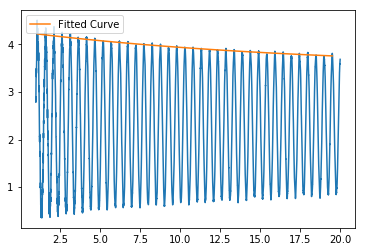

In [18]:
# Definimos la función que ajusta
def func(tp, a, b,c):
    return a + b * np.exp(-c*tp)

# Hacemos el ajuste
popt, pcov = optimize.curve_fit(func, tp, yp)

# Graficamos
plt.plot(t,y)
plt.plot(tp, popt[0]+popt[1]*np.exp(-popt[2]*tp), label="Fitted Curve")
plt.legend(loc='upper left')
plt.show()


In [22]:
print(popt[2], '+-', pcov[2,2])

0.0560519812181 +- 0.000417162389712
